In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")

%watermark -n -u -v -iv -w

Last updated: Thu Jul 28 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

pymc      : 4.1.3
arviz     : 0.12.1
numpy     : 1.23.1
scipy     : 1.8.1
matplotlib: 3.5.2
pandas    : 1.4.3
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]

Watermark: 2.3.1



In [3]:
def z(X):
    return ( (X - np.mean(X)) / np.std(X) ) 

In [4]:
## posterior predictive for 2d regression

def regression_plot(data_frame, trace_obj, model_obj, predict_var, expect_var, out_var):
    posterior_sample = pm.sample_posterior_predictive(trace_obj, model=model_obj)
    ex_post = trace_obj.posterior[expect_var]
    #axis 0 = chain, axis 1 = sample
    ex_mean = ex_post.mean(axis=(0,1))

    _,ax = plt.subplots()
    az.plot_hdi(data_frame[predict_var], ex_post, ax=ax)
    az.plot_hdi(data_frame[predict_var], posterior_sample.posterior_predictive[out_var], ax=ax)
    ax.plot(data_frame[predict_var], data_frame[out_var], "o",alpha=0.5)
    ax.plot(data_frame[predict_var], ex_mean)

In [5]:
data = pd.read_csv("Data/WaffleDivorce.csv", sep=";")

In [6]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


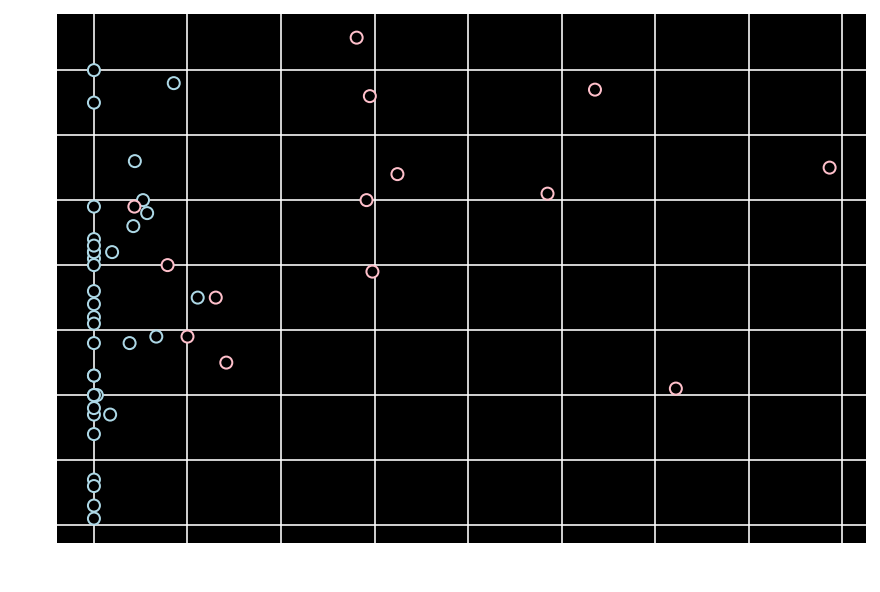

In [7]:
_, ax = plt.subplots()
ax.scatter(data["WaffleHouses"]/data["Population"], data["Divorce"], lw=1, color="black",
edgecolor = data["South"].map({1 : "pink", 0 : "lightblue"}))

In [8]:
## standardize the data

for x in ["Divorce", "Marriage", "MedianAgeMarriage"]:
    data[x + "_raw"] = data[x]
    data[x] = z(data[x])

data.head()


,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,Divorce_raw,Marriage_raw,MedianAgeMarriage_raw
0,Alabama,AL,4.78,-0.612445,0.022874,1.27,1.671000,0.79,128,1,435080,964201,0.45,12.7,20.2,25.3
1,Alaska,AK,0.71,-0.693671,1.565536,2.93,1.560044,2.05,0,0,0,0,0.00,12.5,26.0,25.2
2,Arizona,AZ,6.33,-0.206314,0.049472,0.98,0.616916,0.74,18,0,0,0,0.00,10.8,20.3,25.8
3,Arkansas,AR,2.92,-1.424706,1.671927,1.70,2.114824,1.22,41,1,111115,435450,0.26,13.5,26.4,24.3
4,California,CA,37.25,0.605947,-0.269700,0.39,-0.936470,0.24,0,0,0,379994,0.00,8.0,19.1,26.8


In [9]:
predictor_var, ex_var, outcome_var = "MedianAgeMarriage", "mu", "Divorce"
## .values converts to numpy array
outcome_data = data[outcome_var].values

In [10]:

with pm.Model() as m5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic(ex_var, a + bA * data[predictor_var].values)
    div_rate = pm.Normal(outcome_var, mu, s, observed=outcome_data)
    prior_samples = pm.sample_prior_predictive(samples=1000)
    trace5_1 = pm.sample(1000, tune=1000)
    post_samp = pm.sample_posterior_predictive(trace5_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'bA'}>,
        <AxesSubplot:title={'center':'bA'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>]], dtype=object)

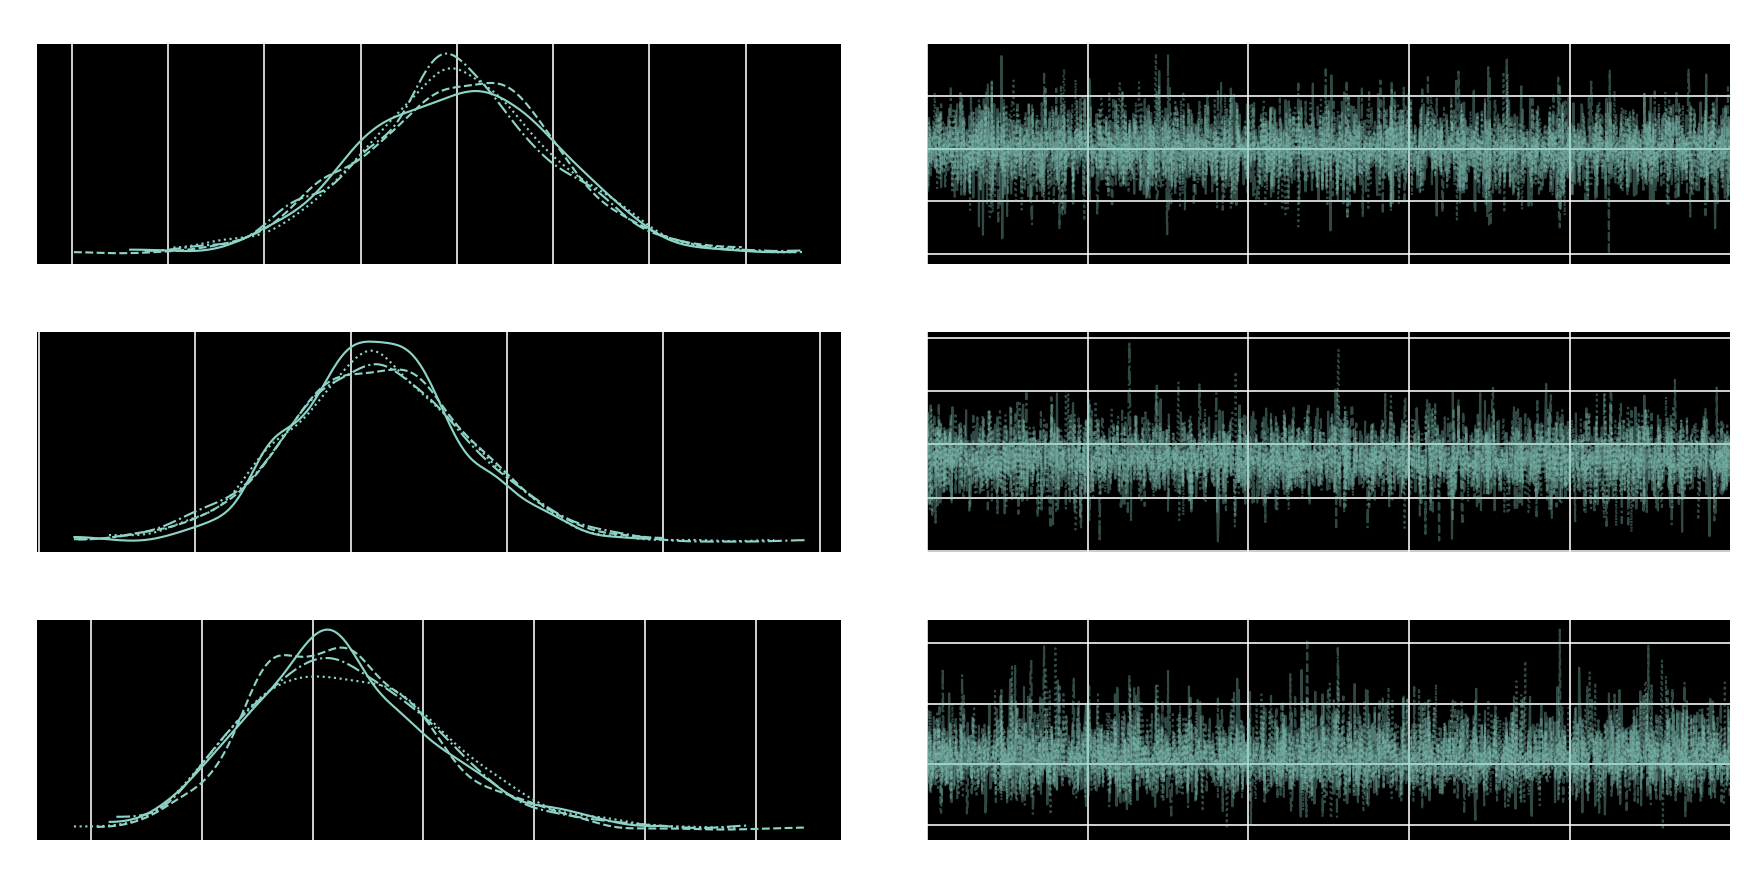

In [11]:
az.plot_trace(trace5_1, ["~mu"])

prior predictive

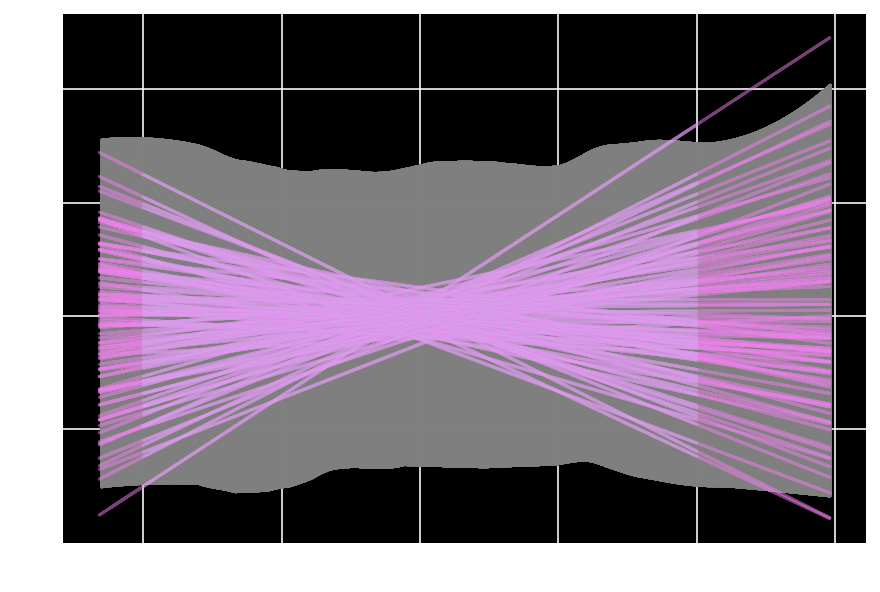

In [12]:
x = np.linspace(2,-2,50)

# chain 0
apriors = np.array(prior_samples.prior["a"][0])
bApriors = np.array(prior_samples.prior["bA"][0])
ex_priors = np.array(prior_samples.prior[ex_var][0])

_,ax = plt.subplots()
for i in range(100):
    #using arbitrary x values
    ax.plot(x, apriors[i] + bApriors[i] * x, alpha=0.5, color="lightblue")
    #using prior samples (identical results)
    ax.plot(data[predictor_var], ex_priors[i], alpha=0.5, color="violet")
    az.plot_hdi(data[predictor_var], prior_samples.prior_predictive[outcome_var], color="gray")


posterior predictive

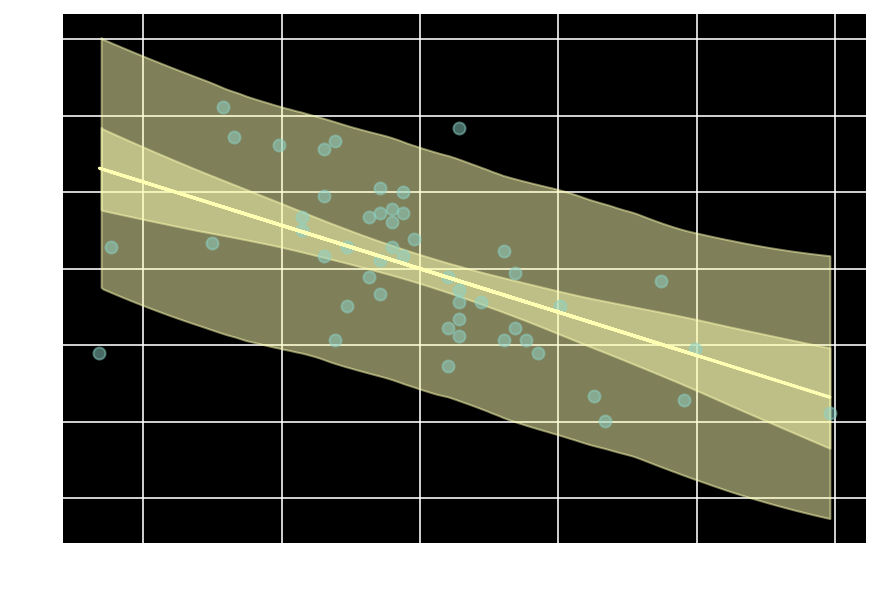

In [13]:
regression_plot(data, trace5_1, m5_1, predictor_var, ex_var, outcome_var)

In [14]:
predictor_var = "Marriage"

with pm.Model() as m5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    s = pm.Exponential("s",1)
    mu = pm.Deterministic(ex_var, a + bM * data[predictor_var].values)
    div_rate = pm.Normal(outcome_var, mu, s, observed=outcome_data)
    prior_samples = pm.sample_prior_predictive(samples=1000)
    trace5_2 = pm.sample(1000, tune=1000)
    post_samp = pm.sample_posterior_predictive(trace5_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'bM'}>,
        <AxesSubplot:title={'center':'bM'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>]], dtype=object)

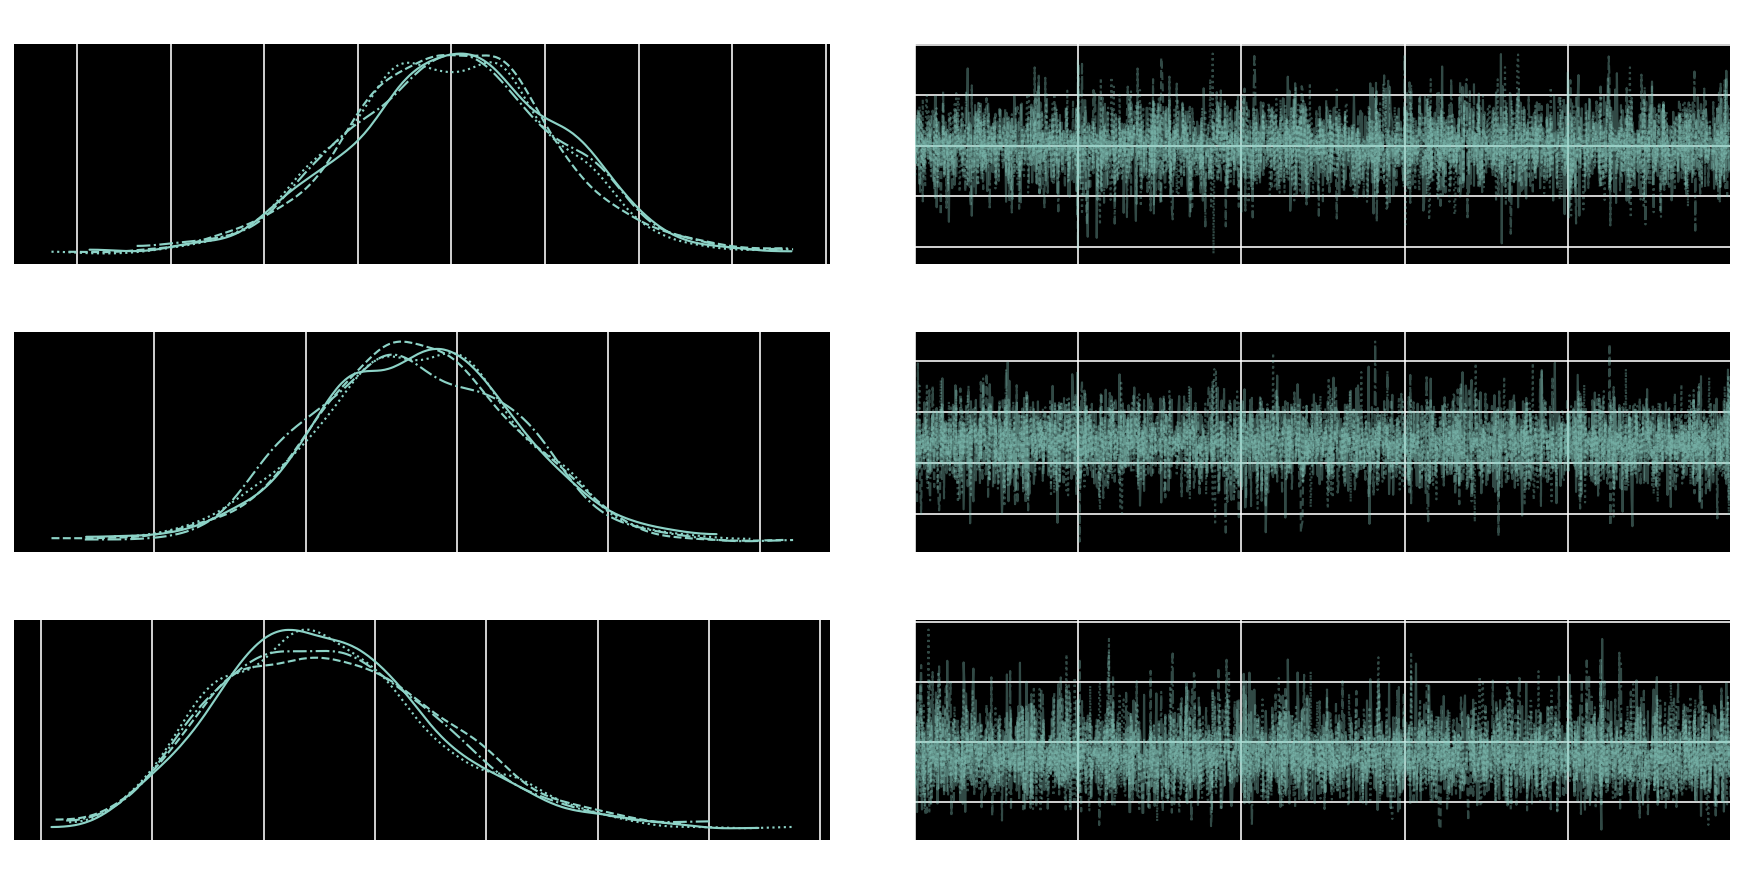

In [15]:
az.plot_trace(trace5_2, ["~mu"])

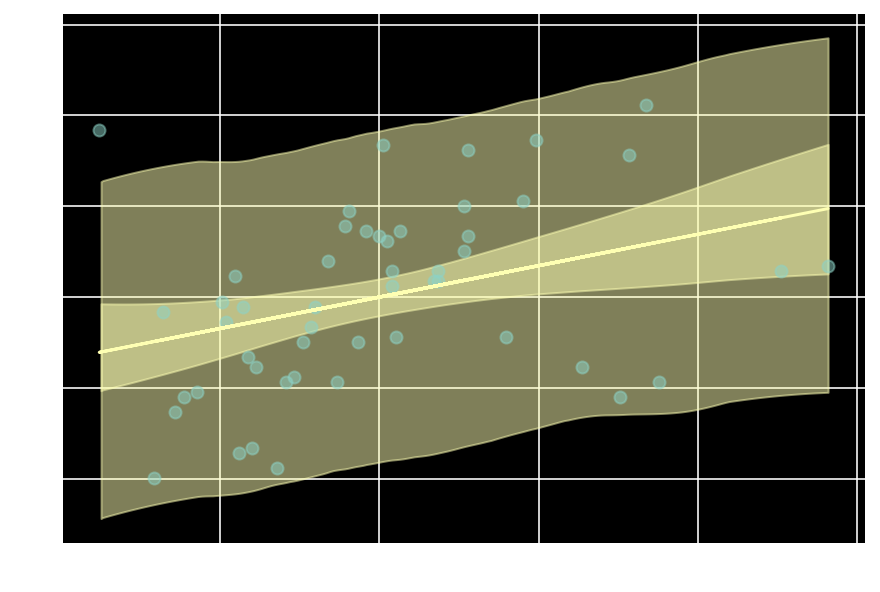

In [16]:
regression_plot(data, trace5_2, m5_2, predictor_var, ex_var, outcome_var)

In [17]:
A = data["MedianAgeMarriage"].values
M = data["Marriage"].values

with pm.Model() as m5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic("mu", a + bA * A + bM * M)
    div_rate = pm.Normal(outcome_var, mu, s, observed=outcome_data)
    prior_samples = pm.sample_prior_predictive(samples=1000)
    trace5_3 = pm.sample(1000, tune=1000)
    post_samp = pm.sample_posterior_predictive(trace5_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'bA'}>,
        <AxesSubplot:title={'center':'bA'}>],
       [<AxesSubplot:title={'center':'bM'}>,
        <AxesSubplot:title={'center':'bM'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>]], dtype=object)

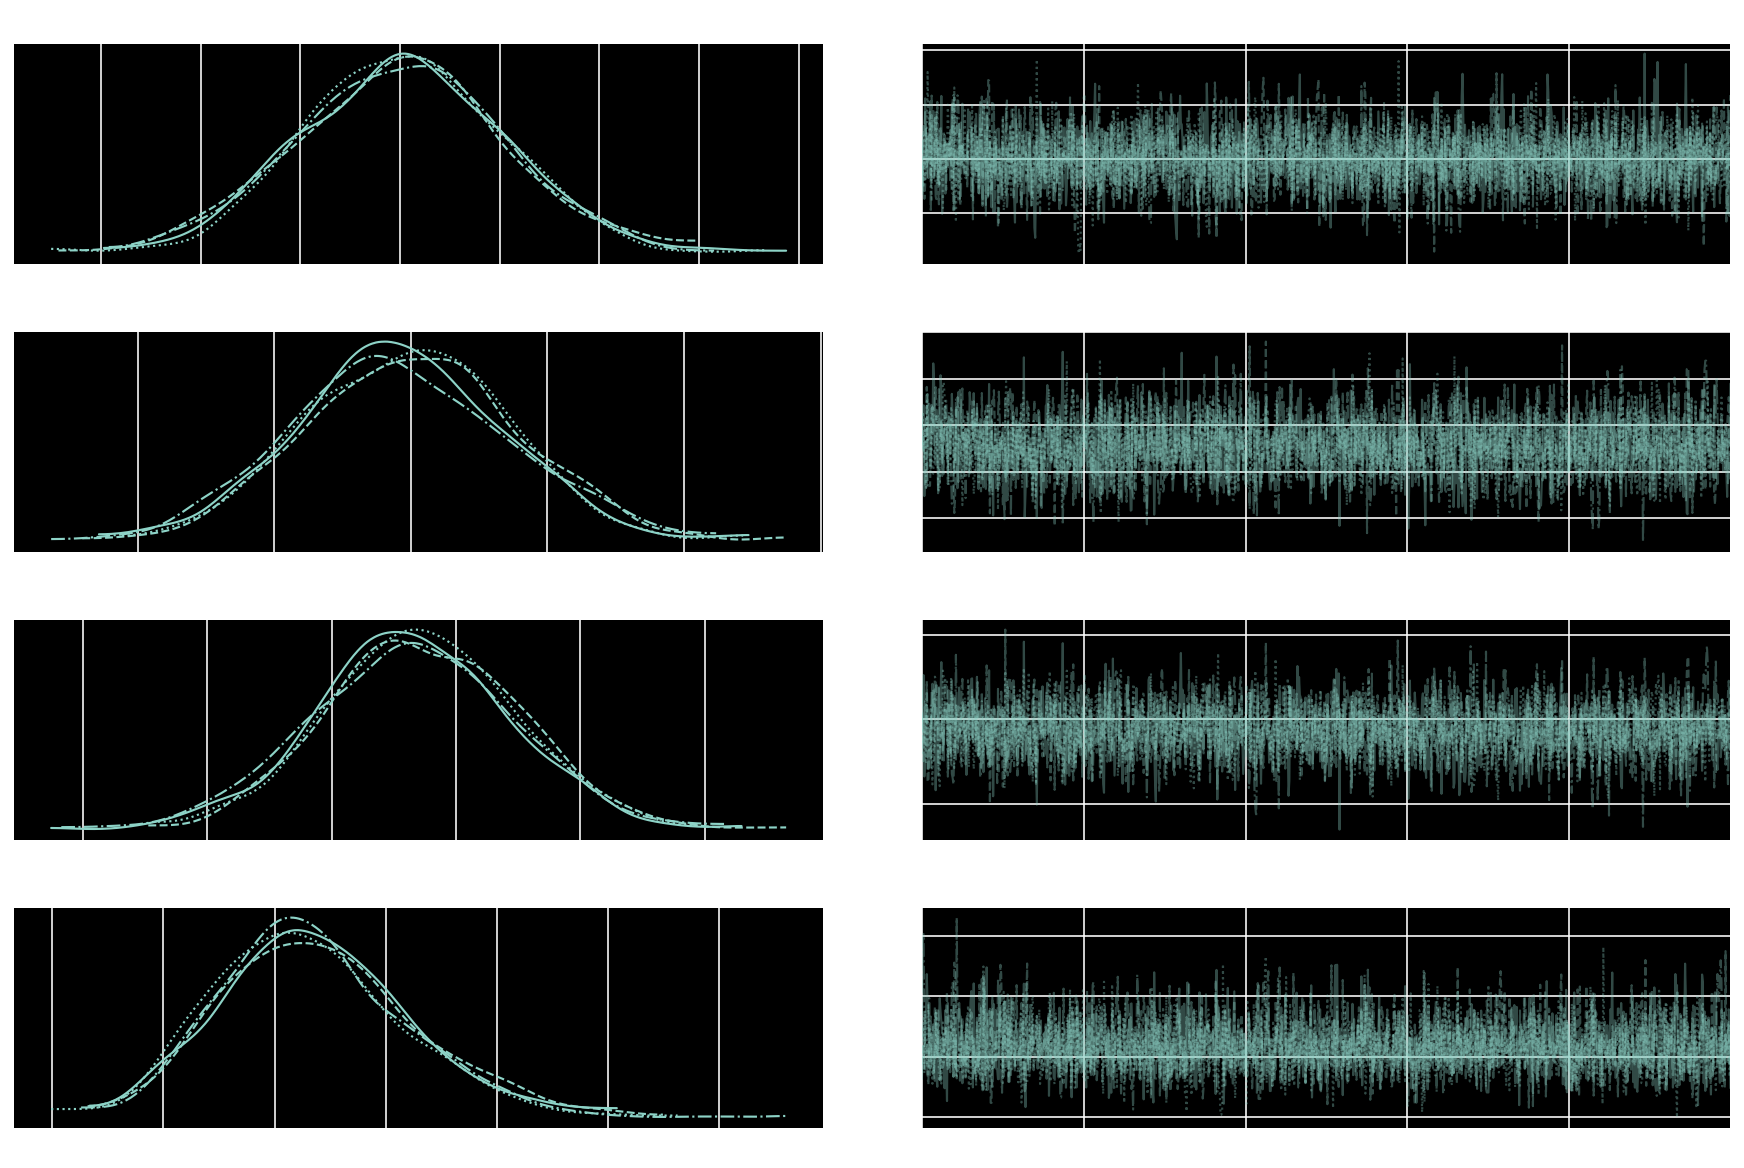

In [18]:
az.plot_trace(trace5_3, var_names=["~mu"])

In [19]:
az.summary(trace5_3, var_names=["~mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.002,0.103,-0.191,0.197,0.002,0.002,3523.0,3034.0,1.0
bA,-0.609,0.154,-0.888,-0.313,0.003,0.002,2517.0,2792.0,1.0
bM,-0.062,0.155,-0.370,0.215,0.003,0.002,2657.0,2946.0,1.0
s,0.835,0.086,0.683,1.000,0.002,0.001,3235.0,2751.0,1.0


marRate only has an effect on divRate in models missing age

marRate and divRate are conditionally independent given age

A -> M, A -> D

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

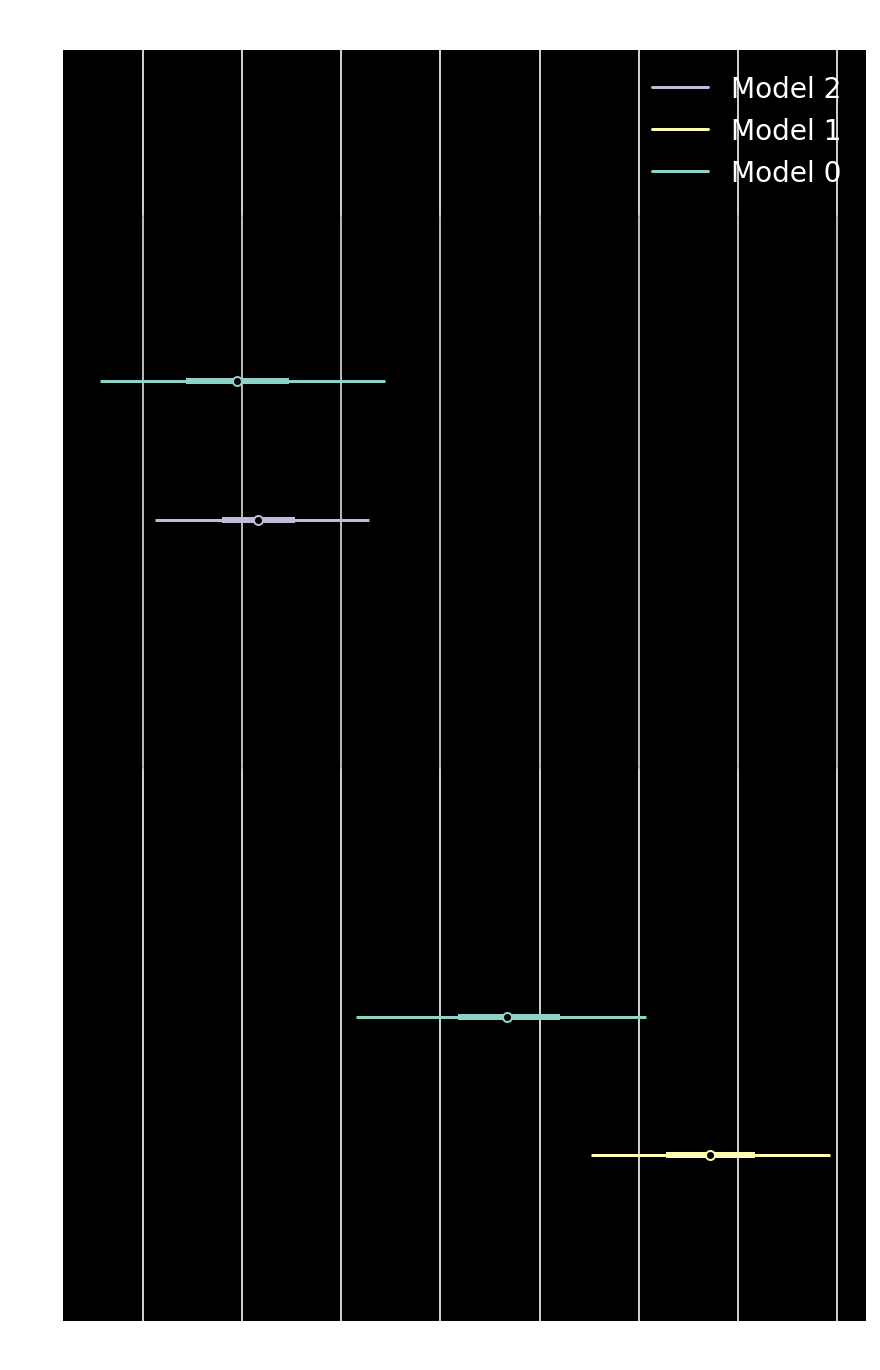

In [20]:
az.plot_forest([trace5_3,trace5_2,trace5_1], var_names=["bA", "bM"], combined=True)

manually removing the effect of Age using Marriage Rate residuals

this happens automatically in the multiple regression above

In [21]:
with pm.Model() as m5_4:
    a = pm.Normal("a", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic(ex_var, a + bAM * A)
    marRate = pm.Normal("Marriage", mu, s, observed = data["Marriage"].values)
    trace5_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bAM, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [22]:
mu54mean = trace5_4.posterior[ex_var].mean(axis=(0,1))
data["Mar~Age_resid"] = data["Marriage"] - mu54mean
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,Divorce_raw,Marriage_raw,MedianAgeMarriage_raw,Mar~Age_resid
0,Alabama,AL,4.78,-0.612445,0.022874,1.27,1.671000,0.79,128,1,435080,964201,0.45,12.7,20.2,25.3,-0.400953
1,Alaska,AK,0.71,-0.693671,1.565536,2.93,1.560044,2.05,0,0,0,0,0.00,12.5,26.0,25.2,1.085396
2,Arizona,AZ,6.33,-0.206314,0.049472,0.98,0.616916,0.74,18,0,0,0,0.00,10.8,20.3,25.8,-0.092788
3,Arkansas,AR,2.92,-1.424706,1.671927,1.70,2.114824,1.22,41,1,111115,435450,0.26,13.5,26.4,24.3,0.684965
4,California,CA,37.25,0.605947,-0.269700,0.39,-0.936470,0.24,0,0,0,379994,0.00,8.0,19.1,26.8,0.151175


In [23]:
predictor_var = "Mar~Age_resid"

with pm.Model() as m5_4b:
    a = pm.Normal("a", 0, 0.2)
    bR = pm.Normal("bR", 0, 0.5)
    s = pm.Exponential("s", 1)
    mu = pm.Deterministic(ex_var, a + bR * data[predictor_var].values)
    div_rate = pm.Normal(outcome_var, mu, s, observed=outcome_data)
    trace5_4b = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bR, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Fig 5.4 lower left

additional effect of Marriage Rate after accounting for Age -> Marriage Rate

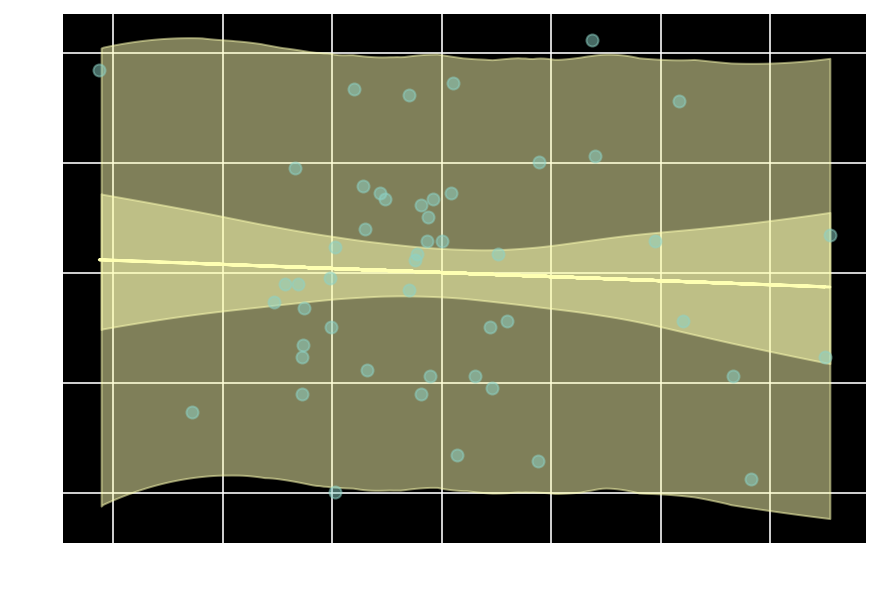

In [24]:
regression_plot(data, trace5_4b, m5_4b, predictor_var, ex_var, outcome_var)

posterior prediction plot

note regression to the mean at extreme values

<ErrorbarContainer object of 3 artists>

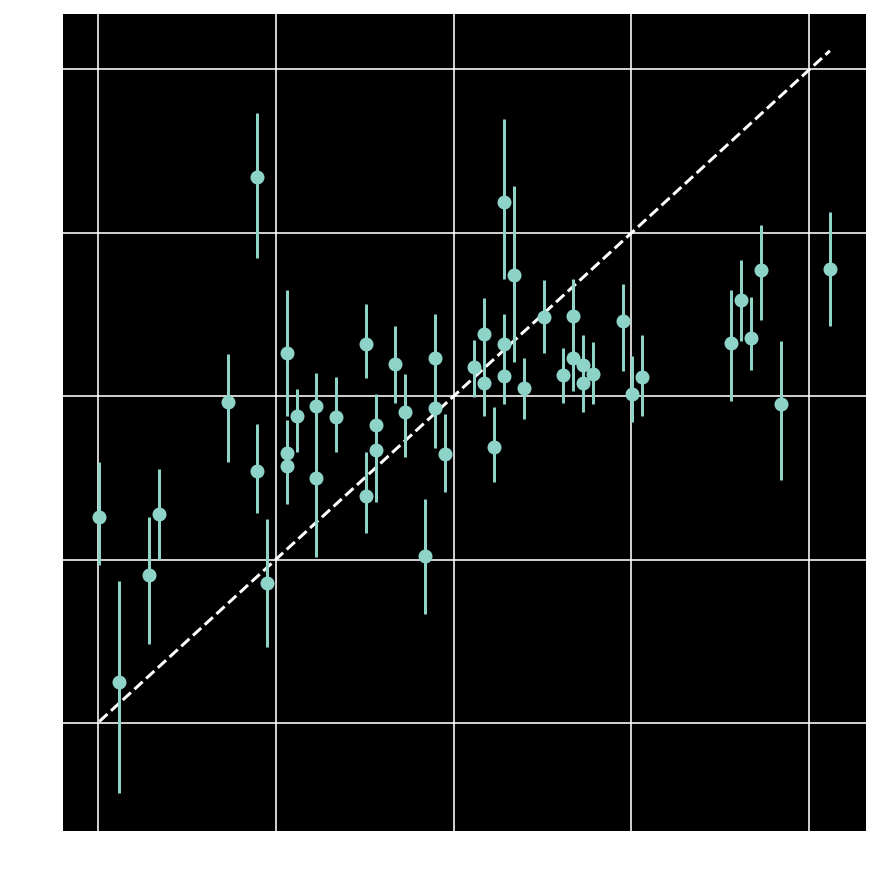

In [25]:
post53 = pm.sample_posterior_predictive(trace5_3, model=m5_3, var_names=[ex_var, outcome_var])

mu_mean = np.array(post53.posterior_predictive["mu"].mean(axis=(0,1)))
mu_PI = az.hdi(post53.posterior_predictive["mu"], 0.89)
D_post_pred = np.array(post53.posterior_predictive["Divorce"].mean(axis=(0,1)))
D_PI = az.hdi(post53.posterior_predictive["Divorce"], 0.89)

_, ax = plt.subplots(figsize=(6,6))
min_x, max_x = outcome_data.min(), outcome_data.max()
ax.plot([min_x, max_x], [min_x, max_x], "w--")
ax.errorbar(outcome_data, D_post_pred, fmt="o", yerr=np.abs(D_post_pred - mu_PI.to_array()[0].T))
